In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128 #***
epochs = 50
data_augmentation = True
num_classes = 10

In [0]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
n = 3  
# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

#lets fix depth at 18 as its resnet18 has 18 layers
# depth=18

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [66]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

from keras.utils import np_utils
# convert class labels to binary class labels
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x



In [0]:
from keras.layers import GlobalAveragePooling2D
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    # if (depth - 2) % 6 != 0:
    #     raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 64
    num_res_blocks = int((depth) / 6) -1
    print("num_res_blocks",num_res_blocks)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(4):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x =  GlobalAveragePooling2D()(x)#AveragePooling2D(pool_size=8)(x)
    # y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    # x = AveragePooling2D(pool_size=8)(x)
    # y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [79]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

num_res_blocks 2
Learning rate:  0.001
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 32, 32, 64)   1792        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 32, 32, 64)   256         conv2d_141[0][0]                 
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 32, 32, 64)   0           batch_normalization_120[0][0]    
_____________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6, monitor='val_loss')

callbacks = [checkpoint, lr_reducer]


In [81]:
from keras.preprocessing.image import ImageDataGenerator
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    #Replacing only non default values and using cutout..try mixup also later
    datagen = ImageDataGenerator(horizontal_flip=True,preprocessing_function=get_random_eraser(v_l=0, v_h=1))
    # ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, 
    #                    zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, 
    #                    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, 
    #                    horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format='channels_last', validation_split=0.0, interpolation_order=1, dtype='float32')
    # datagen = ImageDataGenerator(
    #     # set input mean to 0 over the dataset
    #     featurewise_center=False,
    #     # set each sample mean to 0
    #     samplewise_center=False,
    #     # divide inputs by std of dataset
    #     featurewise_std_normalization=False,
    #     # divide each input by its std
    #     samplewise_std_normalization=False,
    #     # apply ZCA whitening
    #     zca_whitening=False,
    #     # epsilon for ZCA whitening
    #     zca_epsilon=1e-06,
    #     # randomly rotate images in the range (deg 0 to 180)
    #     rotation_range=0,
    #     # randomly shift images horizontally
    #     width_shift_range=0.1,
    #     # randomly shift images vertically
    #     height_shift_range=0.1,
    #     # set range for random shear
    #     shear_range=0.,
    #     # set range for random zoom
    #     zoom_range=0.,
    #     # set range for random channel shifts
    #     channel_shift_range=0.,
    #     # set mode for filling points outside the input boundaries
    #     fill_mode='nearest',
    #     # value used for fill_mode = "constant"
    #     cval=0.,
    #     # randomly flip images
    #     horizontal_flip=True,
    #     # randomly flip images
    #     vertical_flip=False,
    #     # set rescaling factor (applied before any other transformation)
    #     rescale=None,
    #     # set function that will be applied on each input
    #     preprocessing_function=None,
    #     # image data format, either "channels_first" or "channels_last"
    #     data_format=None,
    #     # fraction of images reserved for validation (strictly between 0 and 1)
    #     validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,samples_per_epoch = x_train.shape[0],shuffle=True,
                        callbacks=callbacks)
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., epochs=50, verbose=1, workers=4, shuffle=True, callbacks=[<keras.ca..., steps_per_epoch=390)`


Epoch 1/50
390/390 [==============================] - 39s 100ms/step - loss: 2.3176 - acc: 0.4946 - val_loss: 2.5286 - val_acc: 0.4523

Epoch 00001: val_acc improved from -inf to 0.45230, saving model to /content/saved_models/cifar10_ResNet18v1_model.001.h5
Epoch 2/50
390/390 [==============================] - 33s 84ms/step - loss: 1.6117 - acc: 0.6592 - val_loss: 1.6613 - val_acc: 0.6282

Epoch 00002: val_acc improved from 0.45230 to 0.62820, saving model to /content/saved_models/cifar10_ResNet18v1_model.002.h5
Epoch 3/50
390/390 [==============================] - 32s 83ms/step - loss: 1.3122 - acc: 0.7330 - val_loss: 1.7772 - val_acc: 0.6087

Epoch 00003: val_acc did not improve from 0.62820
Epoch 4/50
390/390 [==============================] - 33s 83ms/step - loss: 1.1536 - acc: 0.7701 - val_loss: 1.3005 - val_acc: 0.7203

Epoch 00004: val_acc improved from 0.62820 to 0.72030, saving model to /content/saved_models/cifar10_ResNet18v1_model.004.h5
Epoch 5/50
390/390 [=================

In [0]:
def show_GradCam(input_img):
    input_img = io.imread(input_img)
    input_img = cv2.resize(input_img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
    x = image.img_to_array(input_img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)   

    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    print(class_idx)
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("activation_136") 

    from keras import backend as K
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    print(grads.shape)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    print(pooled_grads.shape)
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]    

    heatmap = np.mean(conv_layer_output_value, axis = -1)
    print(conv_layer_output_value.shape)
    print(heatmap.shape)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(input_img, 0.5, heatmap, 0.5, 0)

    cv2_imshow(input_img)
    cv2_imshow(superimposed_img)

In [0]:
imgs = ["http://getwallpapers.com/wallpaper/full/e/b/9/316315.jpg","http://getwallpapers.com/wallpaper/full/2/8/a/316354.jpg","http://getwallpapers.com/wallpaper/full/9/0/9/316437.jpg"
,"http://getwallpapers.com/wallpaper/full/f/6/2/316502.jpg","http://getwallpapers.com/wallpaper/full/d/5/5/316611.jpg","http://getwallpapers.com/wallpaper/full/3/1/8/645044.jpg"
,"http://getwallpapers.com/wallpaper/full/9/d/c/316713.jpg","http://getwallpapers.com/wallpaper/full/e/6/3/593404.jpg","http://getwallpapers.com/wallpaper/full/0/3/d/317456.jpg"
,"http://getwallpapers.com/wallpaper/full/1/0/4/41347.jpg"]

# model.load_weights('/content/saved_models/cifar10_ResNet18v1_model.047.h5')

1
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


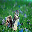

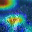

1
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


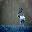

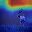

9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


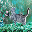

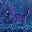

9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


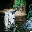

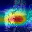

1
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


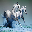

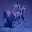

9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


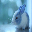

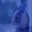

9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


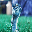

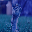

9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


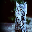

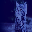

9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


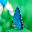

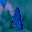

9
(?, 4, 4, 512)
(512,)
(4, 4, 512)
(4, 4)


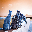

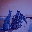

In [87]:
for i in range(10):
  # img = io.imread(imgs[i])
  show_GradCam(imgs[i])